# Shadow Ban with Control Package

This notebook uses the `control` package to solve for shadow banning policies.

In [1]:
!pip install control

     -------------------------------------- 432.8/432.8 kB 9.0 MB/s eta 0:00:00


In [1]:
import numpy as np
import control.optimal as obc
import control as ct

import matplotlib.pyplot as plt
from scripts.content_moderation import *
import networkx as nx


# Load Network

For your network model you need the following inputs:

   1. `A` = adjacency matrix of graph G0
   2. `rates` = array of posting rate of each node
   3. `tau`, `omega` = shift function parameters
   4. `opinions0` = array of initial opinions of each node

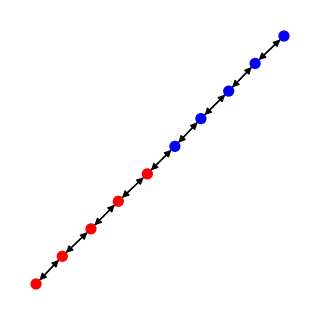

In [21]:
omega = 0.1 # strength of persuasion
tau = .50 # confidence interval, easiness to pursuade

nv = 10
G0 = nx.DiGraph(nx.path_graph(nv) )
for i in range(nv):
    rate = 1
    opinion = i/(nv-1) * 1
    G0.add_node(i, opinion=opinion, rate=rate)
                
rates = np.array([G0.nodes[v]["rate"] for v in G0.nodes()])
opinions0 = np.array([G0.nodes[v]["opinion"] for v in G0.nodes()])


#adjacency matrix of network
A = nx.adjacency_matrix(G0)
A = A.tocoo()
ne = G0.number_of_edges()
#names of edges for shadowbanning in format uij
input_names = []
for e in G0.edges():
    input_names.append(f"u{e[0]}{e[1]}")
#names of nodes opinions in format thetai
output_names = []
for v in G0.nodes():
    output_names.append(f"theta{v}")
    
assert nv == A.shape[0]  #number of nodes in network should equal shape of A
#parameters of network model
params = {'A':A,'rates':rates,'tau':tau,'omega':omega}

#draw network if not too big
if nv<=100:
    pos = nx.kamada_kawai_layout(G0)
    colors = []
    for v in G0.nodes():
        #print(f"{v}: {G.nodes[v]}")
        if (G0.nodes[v]['opinion']<0.5) & (G0.nodes[v]['opinion']>=0):
            colors.append('blue')
        elif (G0.nodes[v]['opinion']>0.5) & (G0.nodes[v]['opinion']<=1):
            colors.append('red')
        elif G0.nodes[v]['opinion']==0.5:
            colors.append('purple')
        else:
            colors.append('green')
    
    plt.figure(figsize = (3,3))
    nx.draw(G0,pos, node_color = colors, node_size = 50)
    #nx.draw_networkx_labels(G,pos)



# Helper Functions

1. `sys_update` = function that returns time derivative of opinions
2. `sys_output` = returns opinions as output of system (not really needed, but whatever)
3. `cost_fun_XXX` = cost function of opinions and control.  This function is time integrated to give the cumulative cost.  The code minimizes this cost.  Make it whatever you like. I found doing linear and quadratic functions makes the code faster, so don't use standard deviation.

In [30]:
def sys_update(t, x, u, params):
    # Get the parameters for the model
    A = params.get('A')         # vehicle wheelbase
    rates = params.get('rates')
    tau = params.get('tau')
    omega = params.get('omega')
    
    
    # Create COO matrix U with data from u at A's locations
    
    U_row = A.row
    U_col = A.col
    U = coo_matrix((u, (U_row, U_col)), shape=(A.shape[0], A.shape[1]))

    # Return the derivative of the state
    return dxdt(x, t, rates, A, tau, omega, U)

def sys_output(t, x, u, params):
    return x                            # return x, y, theta (full state)

#Objective Function
def cost_fun_mean(x, u):
    return -x.mean() - 0.05*u.mean()

#Objective Function
def cost_fun_var_min(x, u):
    return x.var() - 0.05*u.mean()

#Objective Function
def cost_fun_var_max(x, u):
    return x.var() - 0.05*u.mean()

# Create Nonlinear IO System Object

In [31]:
# Define the vehicle steering dynamics as an input/output system
sys = ct.NonlinearIOSystem(
    sys_update, sys_output, states=nv,
    inputs=input_names, outputs = output_names,
    name='path network', params=params)


In [32]:
#inital conditions 
x0 = opinions0
#initial guess of control
u0 = np.ones(ne)
Tf = 200
npts, npts_eval = 10, 100
#bounds on control strength
constraints = [ obc.input_range_constraint(sys, np.zeros(ne), np.ones(ne)) ]


U0 =  np.vstack([u0] * npts).T

timepts = np.linspace(0, Tf, npts, endpoint=True)
t_eval = np.linspace(0, Tf, npts_eval)

resp = ct.input_output_response(
    sys, timepts, U0, x0,
    t_eval= t_eval, params = params)




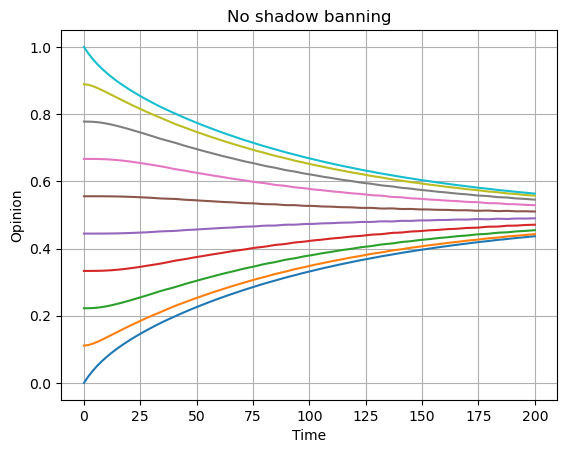

In [33]:
T, Opinions, U = resp.time, resp.outputs, resp.inputs
Opinions = Opinions.T
Opinions_no_agent = Opinions
plt.plot(T, Opinions_no_agent)
plt.title("No shadow banning")
plt.xlabel("Time")
plt.ylabel("Opinion")
plt.grid()
plt.savefig(f"figures/path_network_{nv}_nodes.pdf")
plt.show()

In [34]:
%%time
print("Solving Optimal Control Problem ....")

result = obc.solve_ocp(
    sys, timepts, x0, 
    cost_fun_var_max, 
    constraints,
    initial_guess=u0)

cost = result.cost/Tf  #get time average cost

Solving Optimal Control Problem ....
Summary statistics:
* Cost function calls: 7587
* Constraint calls: 7896
* System simulations: 1
* Final cost: -7.534237550448247
Wall time: 1min 55s


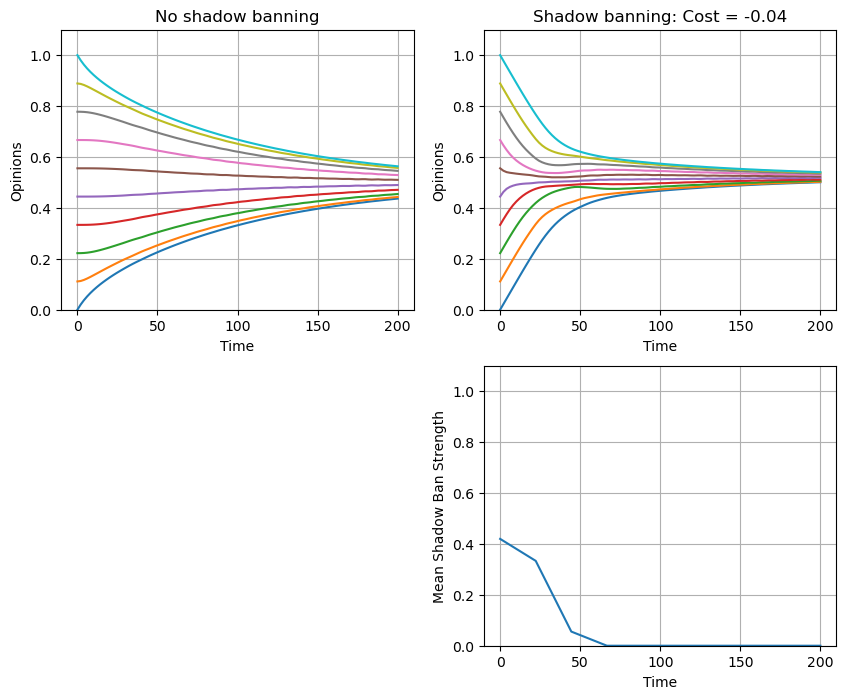

In [35]:
# Simulate the system dynamics with optimal shadow ban control
resp = ct.input_output_response(
    sys, timepts, result.inputs, x0,
    t_eval= t_eval, params = params)


T, Opinions, U = resp.time, resp.outputs, resp.inputs
Opinions = Opinions.T
Shadow_ban_strength = 1-U.mean(axis=0)

plt.figure(figsize = (10,8))
plt.subplot(2,2,1)
plt.plot(T, Opinions_no_agent)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Opinions")
plt.ylim([0,1.1])
plt.title("No shadow banning")

plt.subplot(2,2,2)
plt.plot(T, Opinions)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Opinions")
plt.ylim([0,1.1])
plt.title(f"Shadow banning: Cost = {cost:.2f}")

plt.subplot(2,2,4)
plt.plot(T,Shadow_ban_strength)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Mean Shadow Ban Strength")
plt.ylim([0,1.1])

plt.show()
